In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, splitext
import skfuzzy as fuzz
from sklearn.cluster import KMeans

In [20]:
from os import listdir


input_dir = '../dataset/test'
output_dir = '../dataset/output'
gt_dir = '../dataset/groundtruth'
numImages = 80

onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
files = onlyfiles[0:numImages]

In [21]:
def showSubplotImage(img, titlestr=""):
    plt.imshow(img, cmap='gray', interpolation='bicubic', vmin=0, vmax=255)
    plt.xticks([]), plt.yticks([])
    plt.title(titlestr)
    plt.show()

def setSubplotImage(img, titlestr=""):
    n = len(img)  # Number of images
    
    if n <= 6:
        # If 6 or fewer images, show in a single row
        cols = n
        rows = 1
    else:
        # Otherwise, calculate rows and columns
        cols = int(np.ceil(np.sqrt(n)))
        rows = int(np.ceil(n / cols))

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.ravel()  # Flatten axes for easy indexing

    for i in range(n):
        axs[i].imshow(img[i], cmap='gray', vmin=0, vmax=255)
        axs[i].set_title(titlestr[i] if i < len(titlestr) else "")
        axs[i].axis('off')  # Turn off axes

    # Hide any unused subplots
    for i in range(n, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [22]:
def preprocessing (image) :

    green_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))[1]
    greyScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=0.023, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(green_channel)   

    filtered_img = cv2.GaussianBlur(enhanced_img,(5,5),0)

    return filtered_img , greyScale

In [23]:
def segmentation_k_means (image):
    # convert to 1D array
    image = image.reshape((-1,1)) 
    # convert to np.float32 
    image = np.float32(image) 

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) 

    fig, ax = plt.subplots(10,2, sharey=True) 
    for i in range(10): 
        K = i+3
        # apply K-means algorithm 
        ret,label,center=cv2.kmeans(image, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 
        # Now convert back into uint8, and make original image 
        center = np.uint8(center) 
        res = center[label.flatten()] 
        res2 = res.reshape((image.shape)) 
        # plot the original image and K-means image 
        ax[i, 1].imshow(res2) 
        ax[i,1].set_title('K = %s Image'%K) 
        ax[i, 0].imshow(image) 
        ax[i,0].set_title('Original Image') 



In [25]:
# -*- coding: utf-8 -*-
"""
imageSegment.py

YOUR WORKING FUNCTION

"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


input_dir = 'dataset/test'
output_dir = 'dataset/output'
gt_dir = 'dataset/groundtruth'

# you are allowed to import other Python packages above
##########################

def segmentImage(img):
    # Inputs
    # img: Input image, a 3D numpy array of row*col*3 in BGR format
    #
    # Output
    # outImg: segmentation image
    #
    #########################################################################
    # ADD YOUR CODE BELOW THIS LINE

    green_channel = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]
    greyScale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 2: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=0.023, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(green_channel)   

    # filtered_img = cv2.GaussianBlur(enhanced_img,(5,5),0)

    # median_img = cv2.medianBlur(enhanced_img, 5)

    kernal = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    Topen = cv2.morphologyEx(enhanced_img,cv2.MORPH_OPEN,kernal)
    TopHat = cv2.morphologyEx(Topen, cv2.MORPH_CLOSE, kernal)

    #More morphological operations, erosion then dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
    min_image = cv2.erode(TopHat, kernel)
    min_image = cv2.dilate(min_image, kernel)









    # END OF YOUR CODE
    #########################################################################
    return outImg


In [ ]:
import cv2
import numpy as np
from skimage.morphology import reconstruction

def extract_vessels(image_path):
    """
    Extract vessels from a grayscale image using directional morphological operations.
    
    Parameters:
    image_path (str): Path to the input grayscale image
    
    Returns:
    tuple: Original image, maximum response image, and smoothed image
    """
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Could not load image from path")
    
    # Normalize image to float32 in range [0, 1]
    image_norm = image.astype(np.float32) / 255.0
        
    # Create structuring elements for each direction
    responses = []
    base_se = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 1))
    angles = np.arange(0, 180, 15)  # 12 directions
    
    # Center point for rotation
    center = (base_se.shape[1] // 2, base_se.shape[0] // 2)
    
    for angle in angles:
        # Create rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Calculate new bounds for the rotated structuring element
        bounds = cv2.warpAffine(base_se, rotation_matrix, (7, 7))
        
        # Convert to binary structuring element
        rotated_se = (bounds > 0).astype(np.uint8)
        
        # Apply opening operation on normalized image
        eroded = cv2.erode(image_norm, rotated_se, iterations=1)
        opened = cv2.dilate(eroded, rotated_se, iterations=1)
        
        responses.append(opened)
    
    # Compute maximum response across all directions
    max_response = np.max(responses, axis=0)
    
    # Ensure seed is less than mask for reconstruction
    seed = max_response.copy()
    mask = image_norm.copy()
    
    # Adjust seed to be slightly smaller than mask
    seed = np.minimum(seed, mask)
    
    # Apply reconstruction
    smoothed = reconstruction(seed, mask, method='dilation')
    
    # Clip values to [0, 1] range before converting to uint8
    max_response = np.clip(max_response, 0, 1)
    smoothed = np.clip(smoothed, 0, 1)
    
    # Convert back to uint8 range [0, 255]
    max_response_uint8 = (max_response * 255).round().astype(np.uint8)
    smoothed_uint8 = (smoothed * 255).round().astype(np.uint8)
    
    return image, max_response_uint8, smoothed_uint8

def display_results(original, max_response, smoothed, save_path=None):
    """
    Display or save the results of vessel extraction.
    
    Parameters:
    original: Original image
    max_response: Maximum response image
    smoothed: Smoothed image after reconstruction
    save_path (str, optional): Path to save the results
    """
    # Create a figure with all results
    result = np.hstack((original, max_response, smoothed))
    
    if save_path:
        cv2.imwrite(save_path, result)
    else:
        cv2.imshow("Results (Original | Max Response | Smoothed)", result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# Example usage
if __name__ == "__main__":
    # Path to your image
    image_path = "../dataset/test/07.png"
    
    try:
        # Extract vessels
        original, max_response, smoothed = extract_vessels(image_path)
        
        # Display results
        display_results(original, max_response, smoothed)
        
        # Optionally save results
        # display_results(original, max_response, smoothed, "results.png")
        
    except Exception as e:
        print(f"Error processing image: {str(e)}")

C:\Users\junyao\AppData\Local\Temp\ipykernel_32032\4236605936.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(10,2, sharey=True)


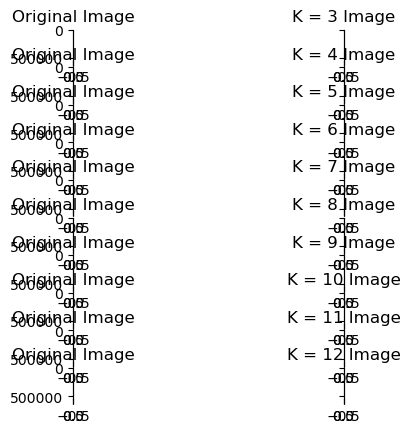

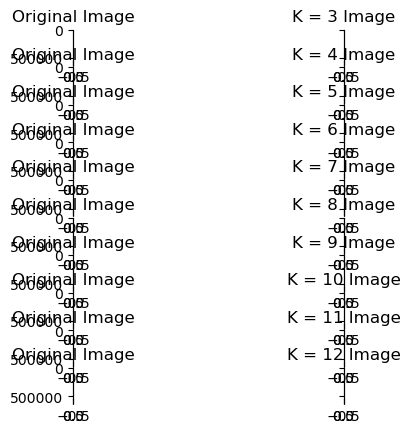

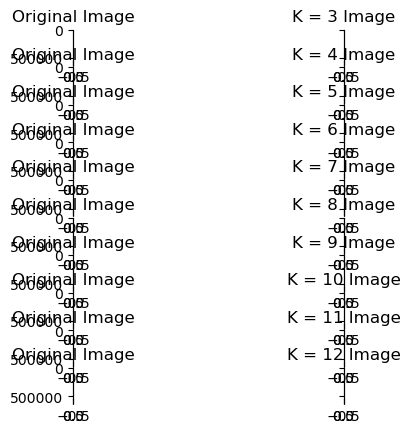

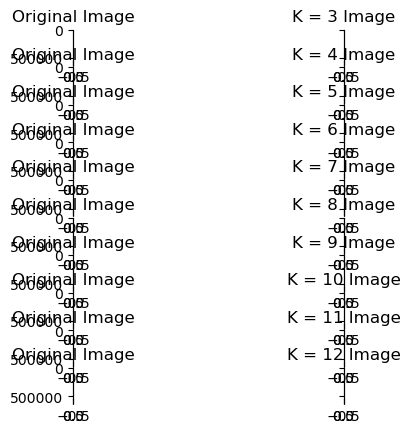

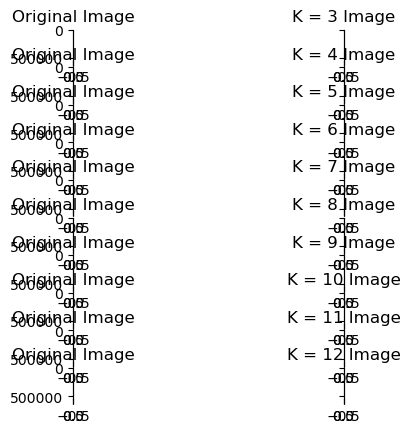

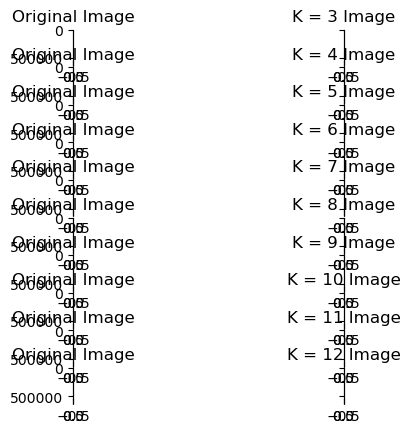

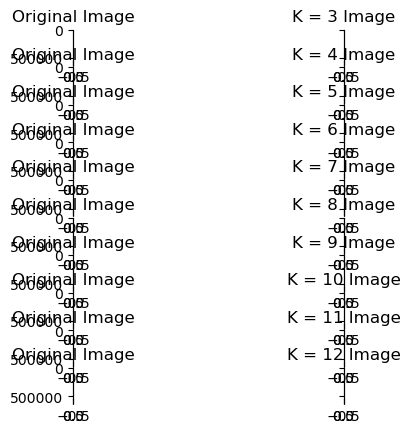

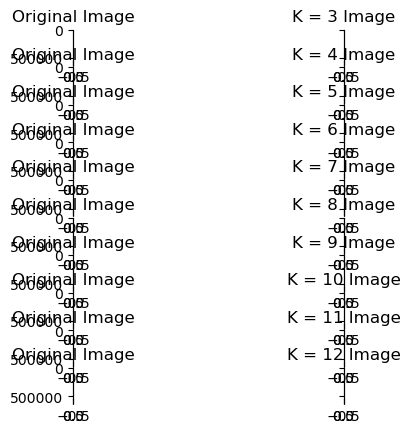

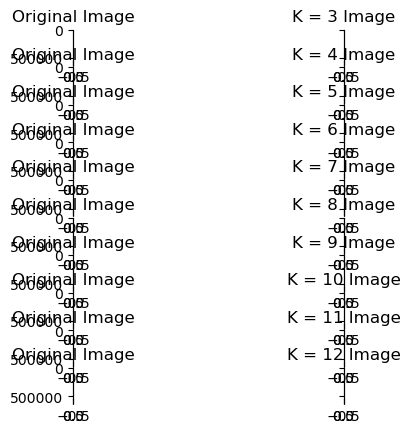

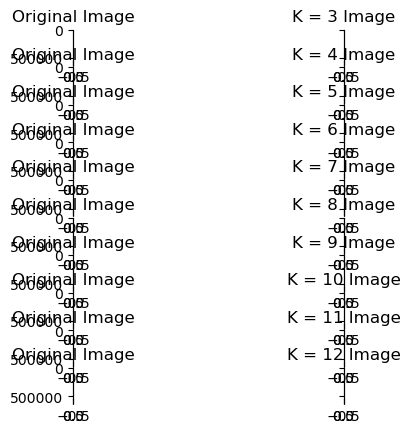

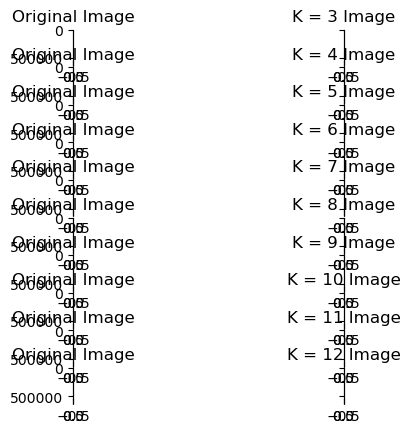

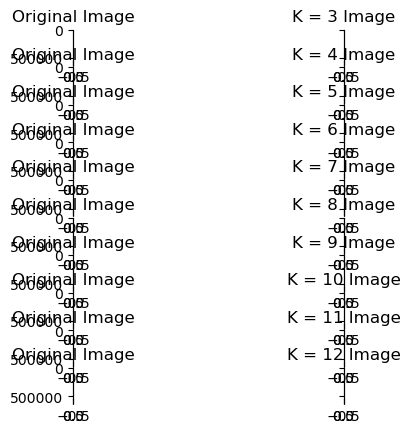

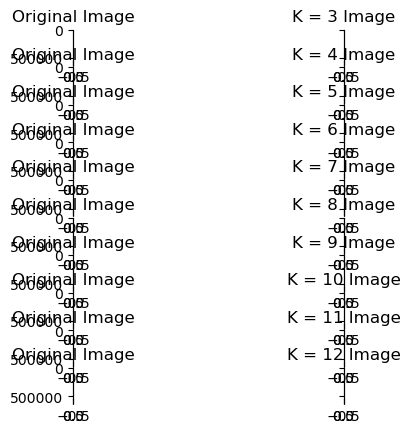

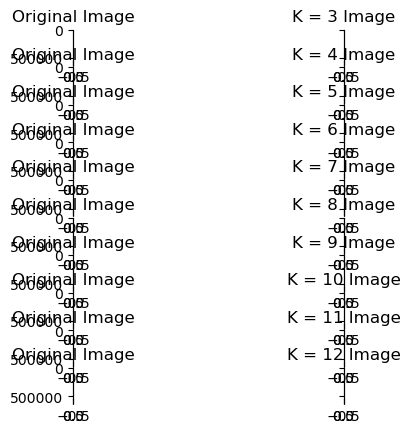

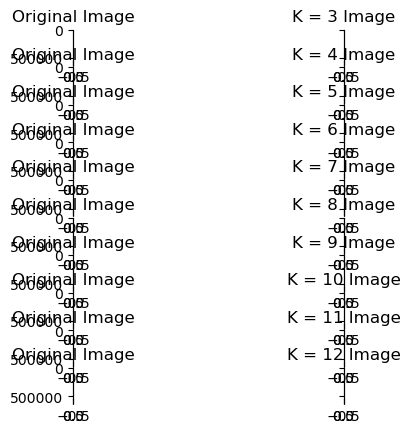

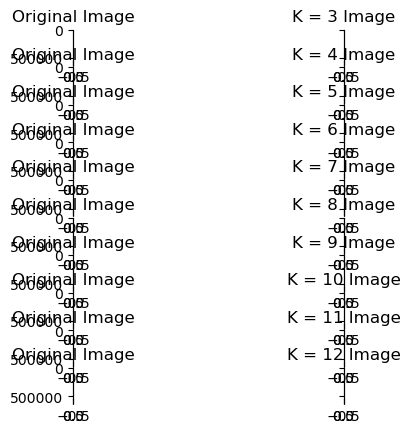

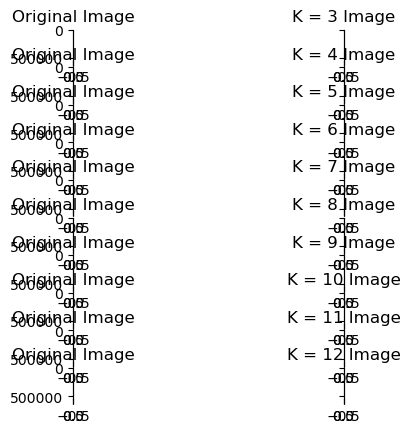

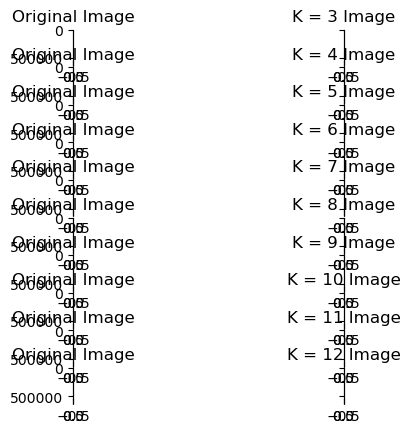

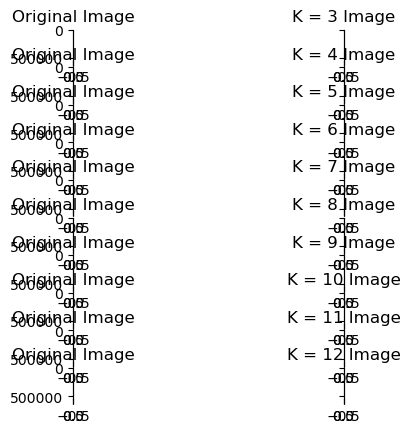

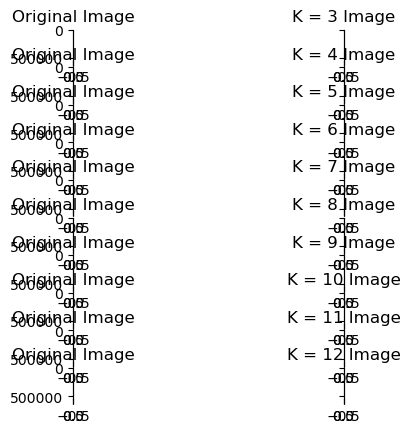

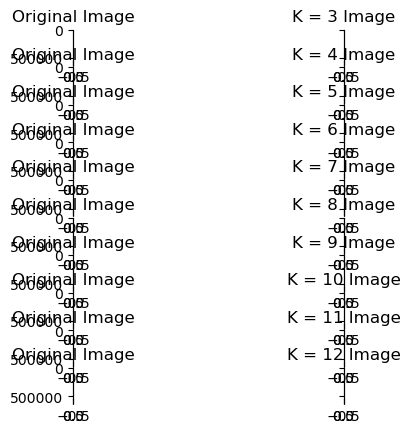

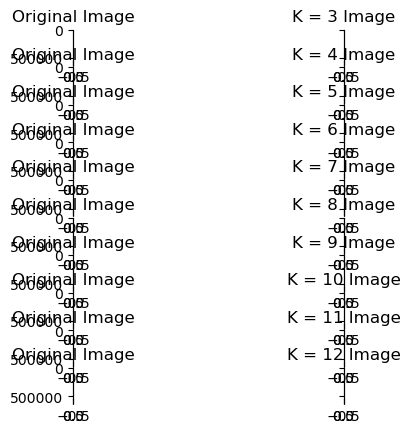

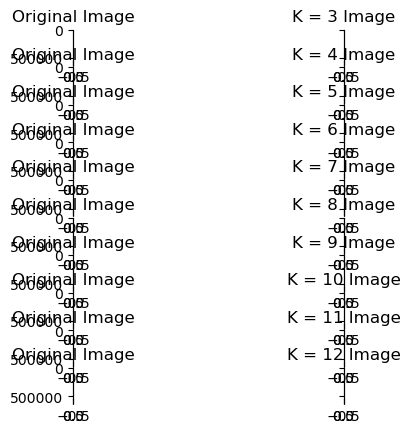

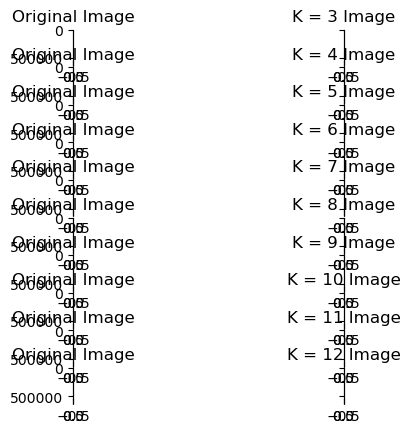

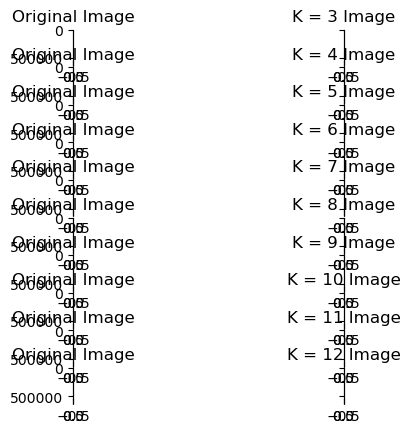

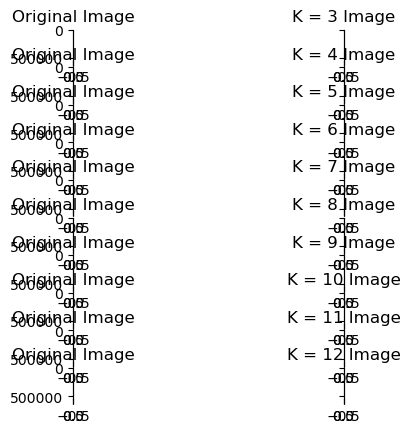

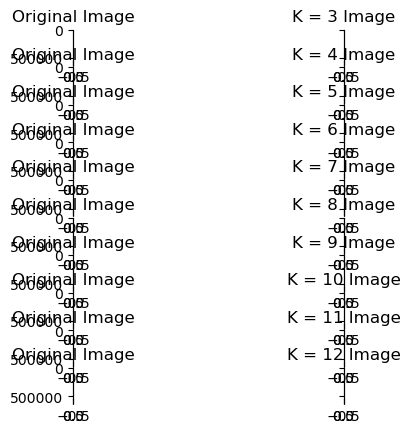

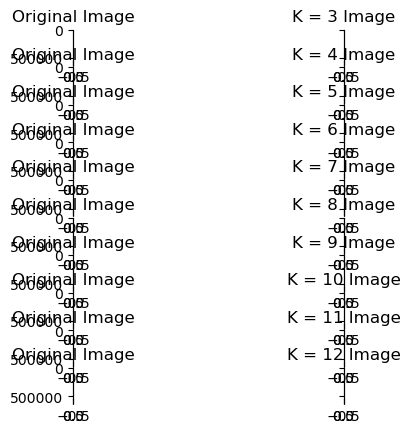

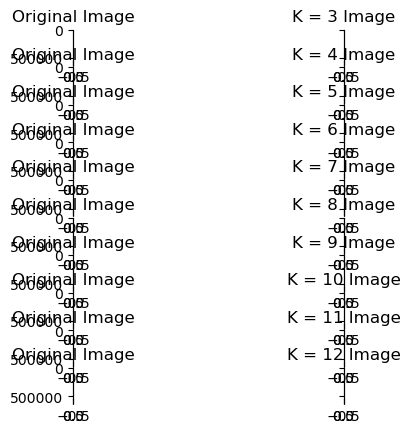

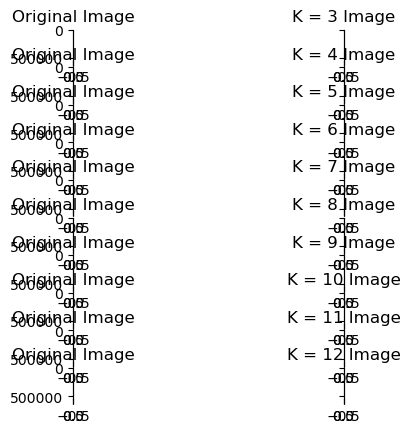

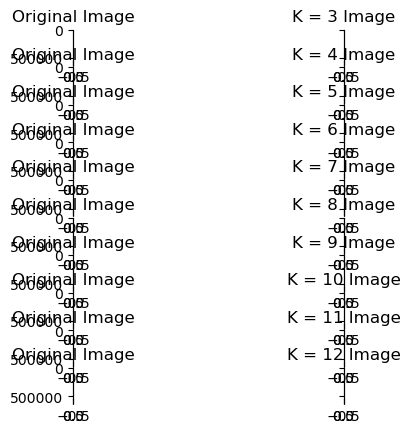

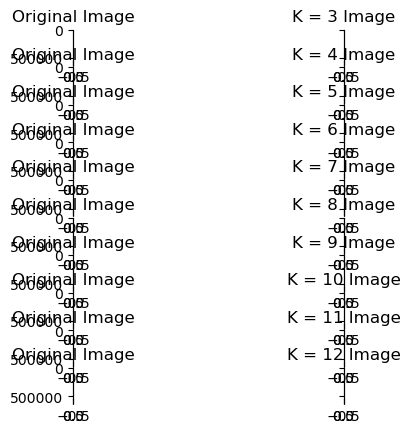

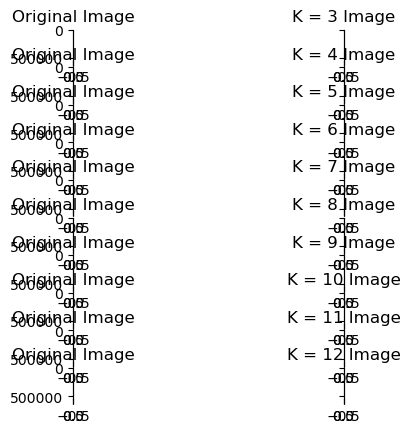

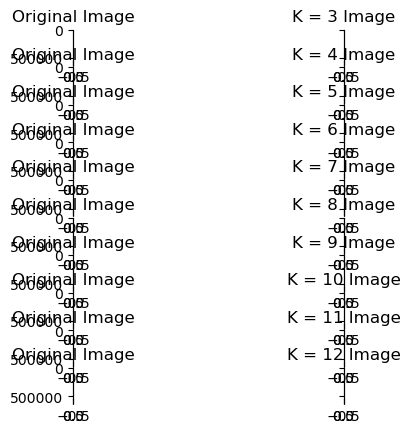

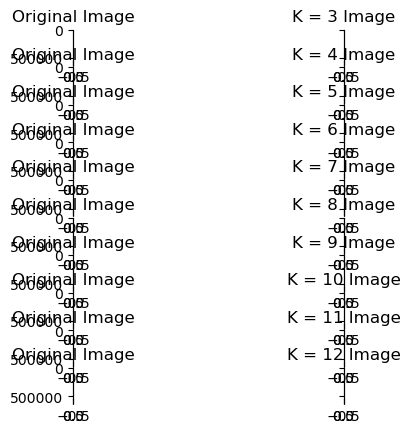

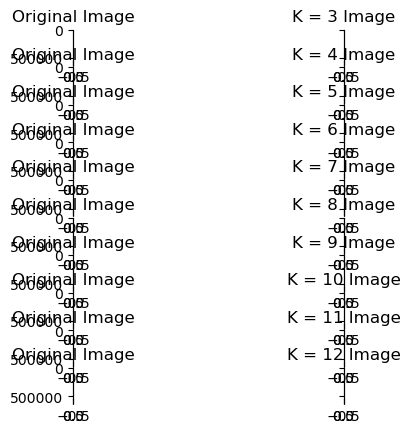

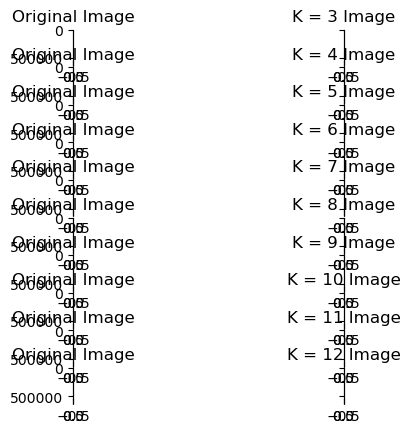

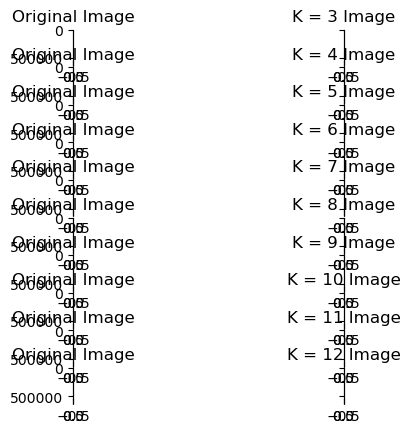

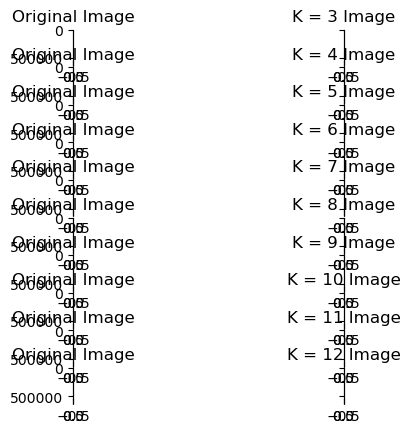

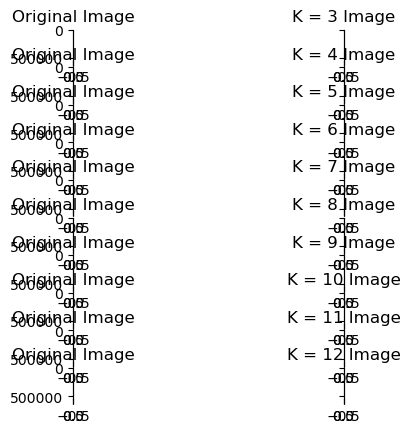

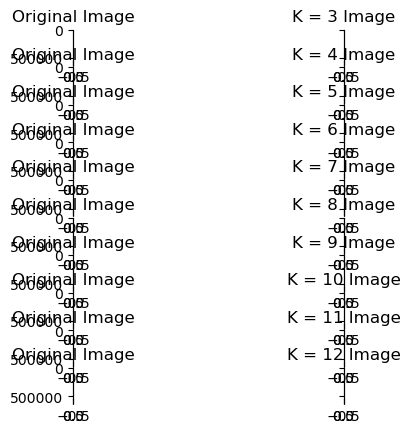

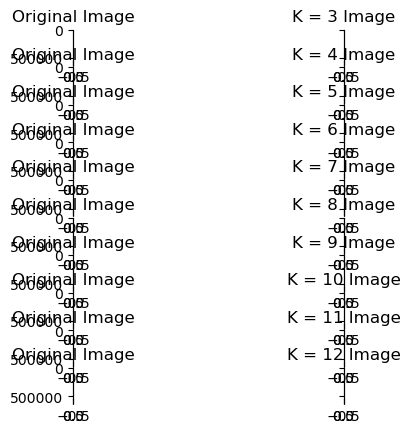

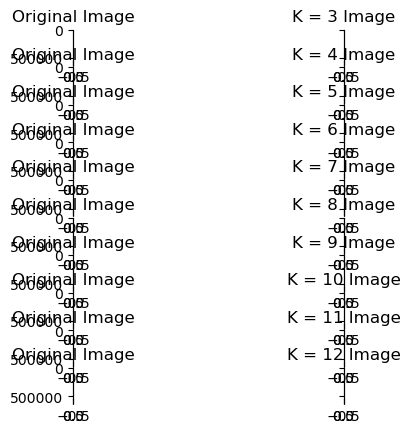

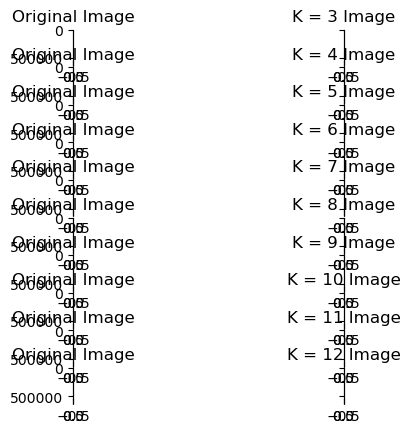

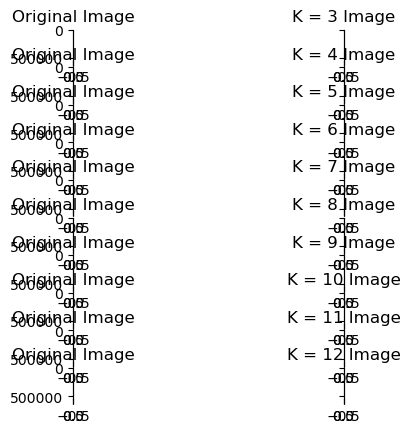

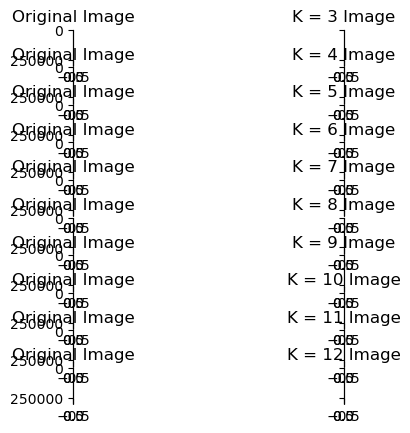

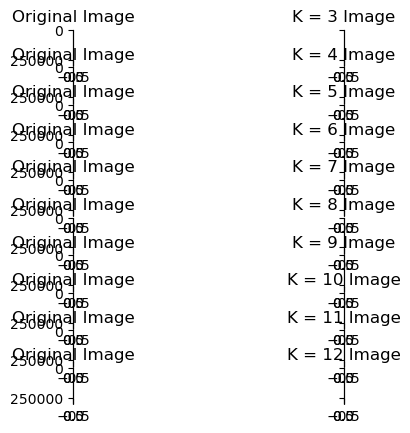

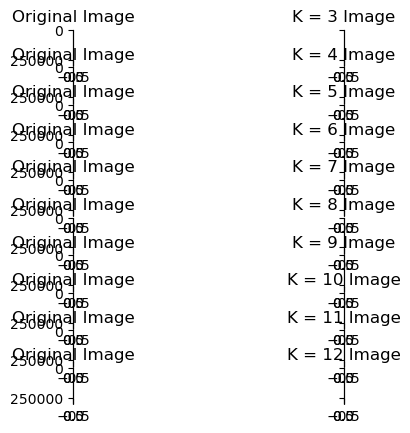

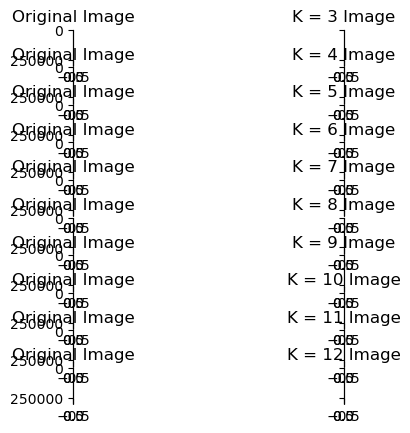

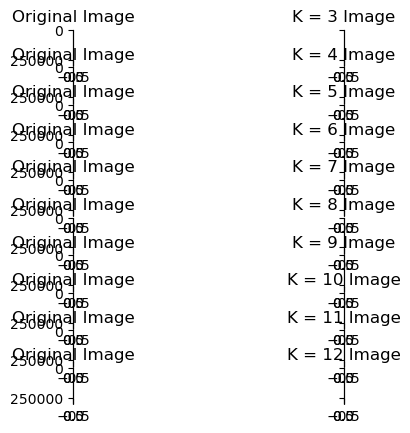

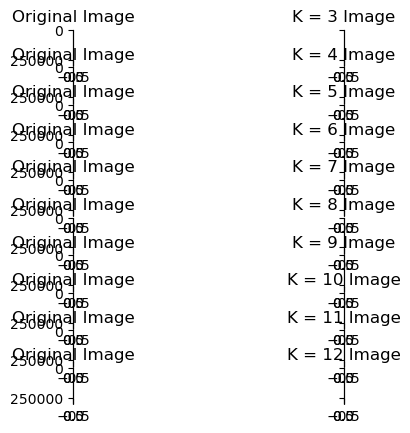

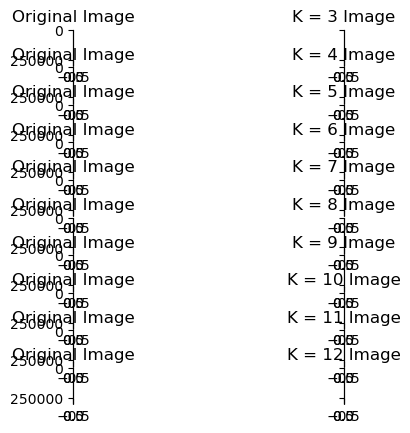

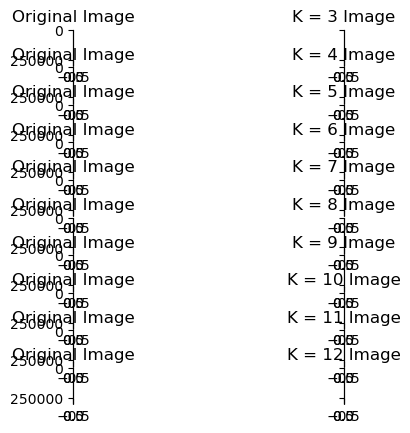

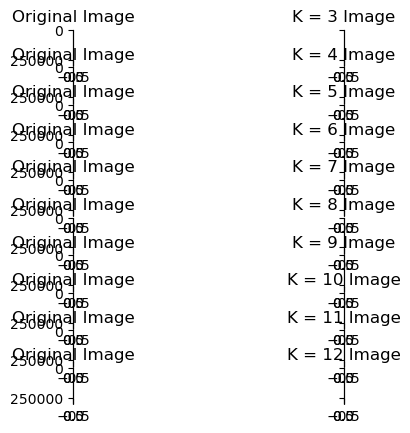

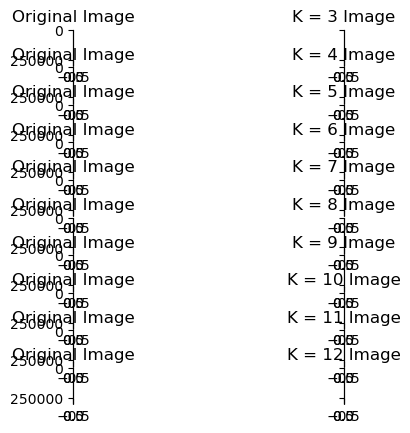

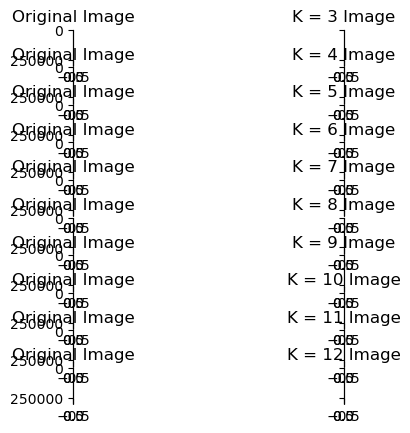

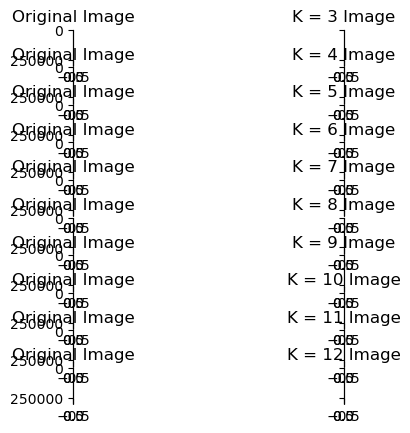

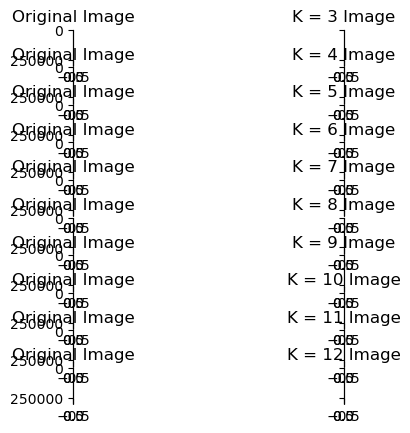

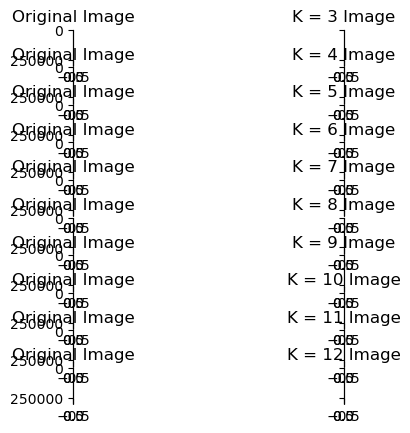

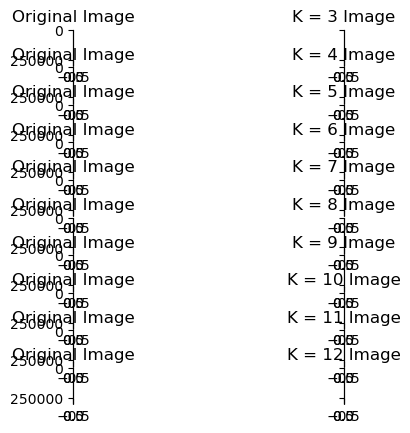

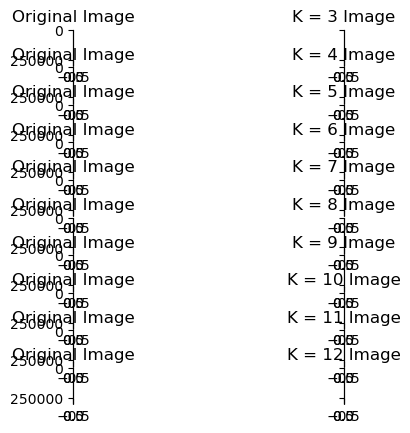

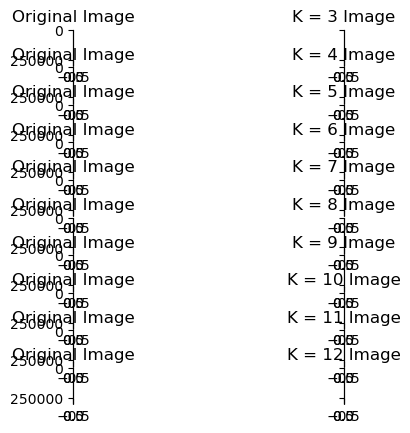

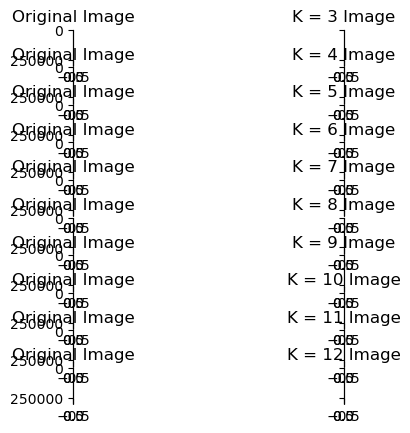

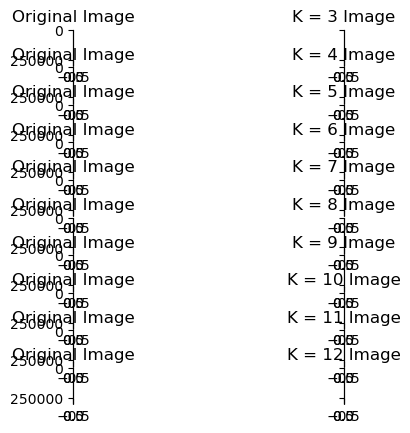

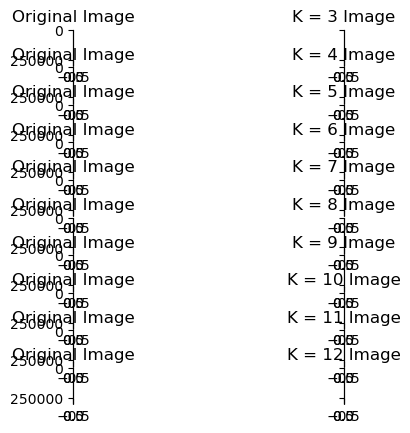

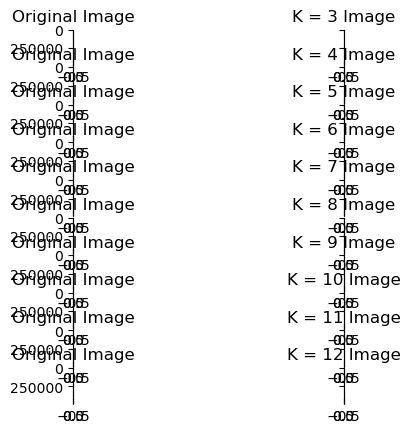

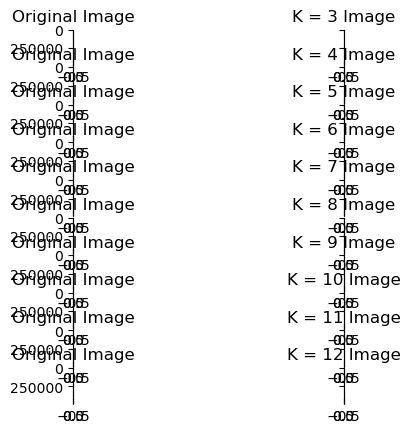

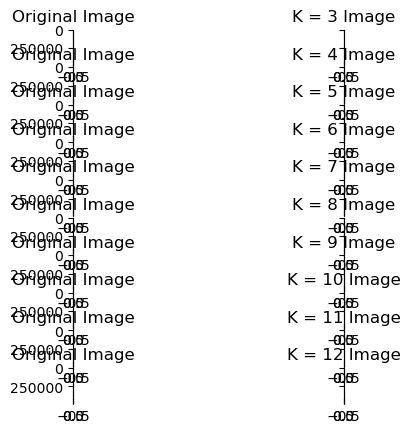

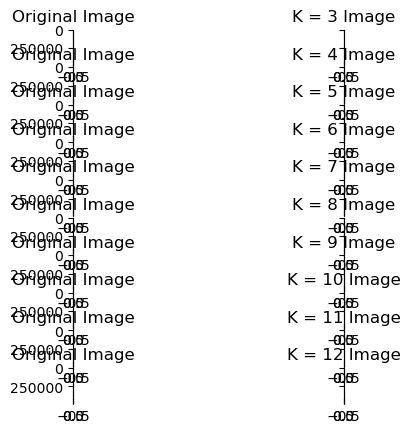

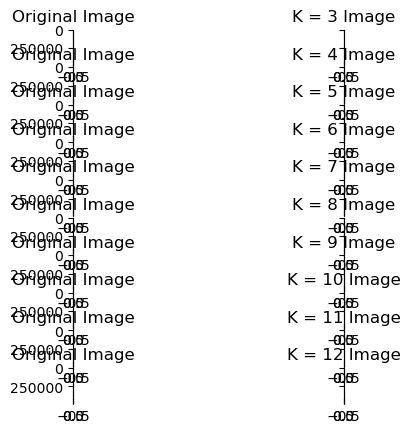

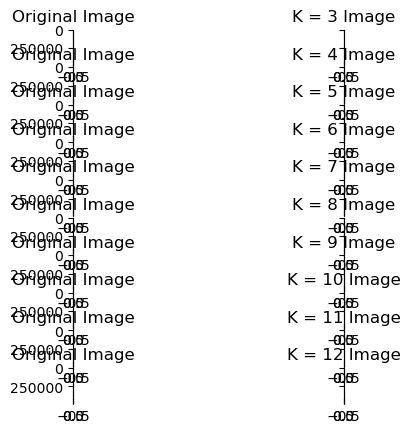

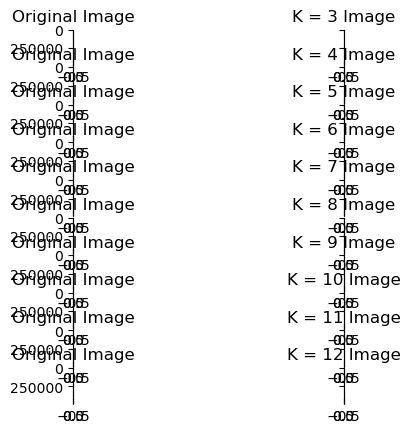

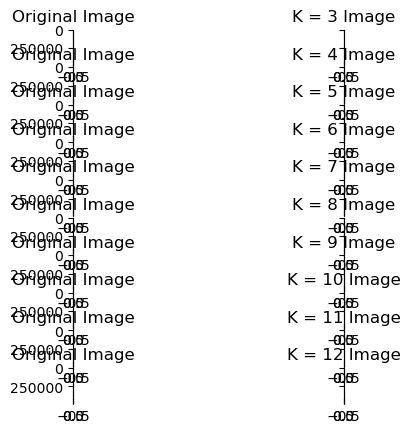

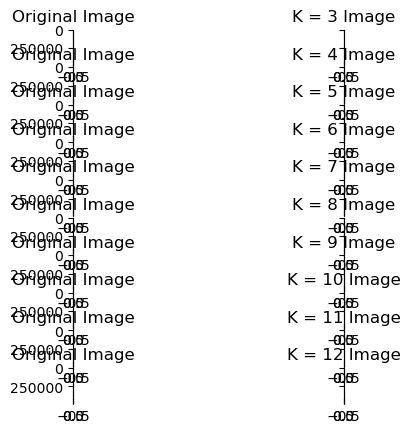

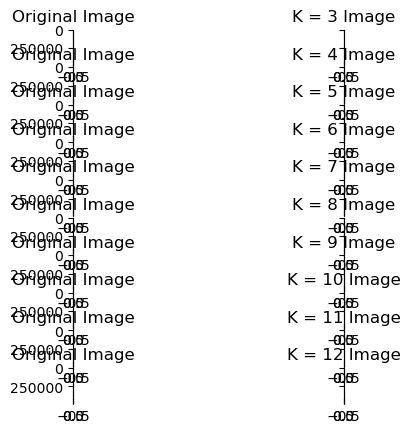

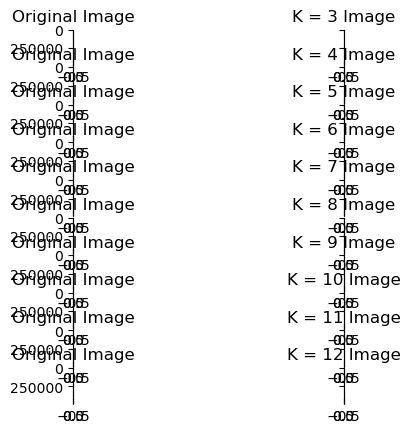

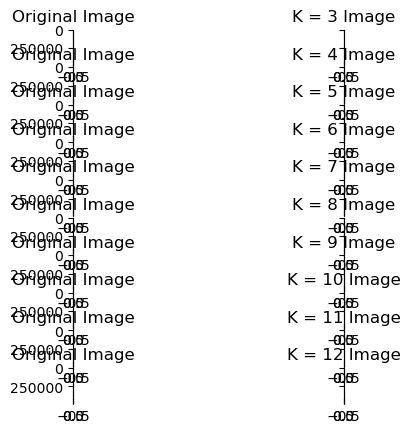

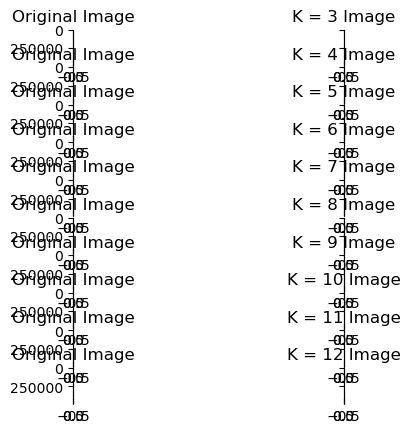

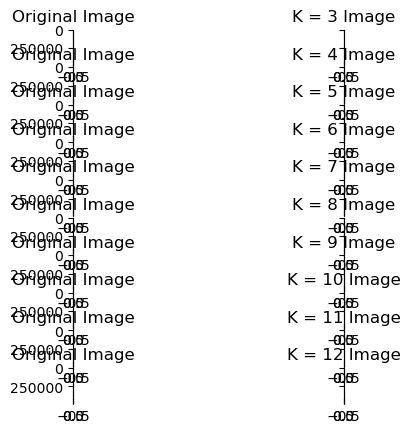

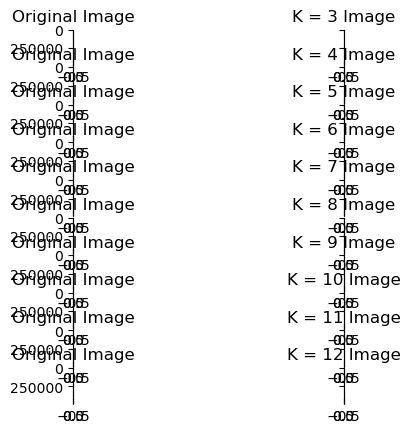

In [24]:
for i,name in enumerate(files):
    inputImg = cv2.imread(input_dir + '/' + name)
    inputImg,greyScale = preprocessing(inputImg)
    edge_binary = segmentation_k_means(inputImg)